***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

2023-05-11 13:57:42.334427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 13:57:45.768703: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/knoor/.conda/envs/tfpy/lib/
2023-05-11 13:57:45.769244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/knoor/.conda/envs/tfpy/lib/
2023-05-11 13:57:45.769264: W tensorflow/compiler/tf

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = posix
• Working Directory = /home/knoor/Downloads/RunningOnServer/HD_CapsNet/Training_and_Analysis/7_Marin_Tree
• Python Version = 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
• TensorFlow Version = 2.11.0
• Keras Version = 2.11.0
• Current Environment = Not Using Anaconda


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1,4" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1,4
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
2 Physical GPUs, 2 Logical GPUs


2023-05-11 13:57:55.758868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 13:58:02.503822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10403 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:1b:00.0, compute capability: 6.1
2023-05-11 13:58:02.527368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10379 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:88:00.0, compute capability: 6.1


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('7_Marine_Tree/HD_CapsNet/Mod_2_9')

FOLDER CREATED =  ../../logs/7_Marine_Tree/HD_CapsNet/Mod_2_9


# Import Dataset : Marine Tree Dataset

In [6]:
dataset = datasets.get_Marine_dataset(output_level='level_depth_3', # 'level_depth_3', 'level_depth_4', 'level_depth_5
#                                       dataset_path ='D:\Datasets\Marine_tree', ## Path to the dataset directory
                                      dataset_path ='/home/knoor/Downloads/RunningOnServer/H-CapsNet_Revision/Dataset/Marine_tree', ## Path to the dataset directory
                                      image_size=(64,64),
                                      batch_size=train_params['batch_size'],
                                      subtype='Combined',
                                      data_normalizing ='normalize',
                                      class_encoding = 'One_Hot_Encoder',
                                      data_augmantation = 'mixup'
                                     )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-11 13:58:41.725745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4497 of 6400
2023-05-11 13:58:45.839525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 13:58:56.052187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4764 of 6400
2023-05-11 13:58:58.598397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


Example =  0


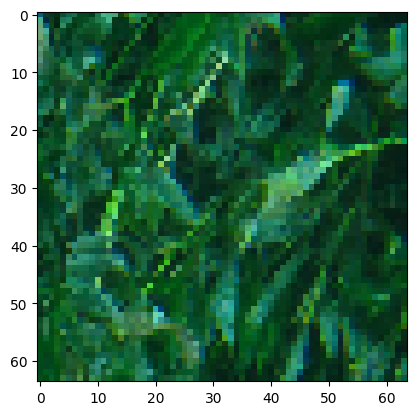

Coarse = {0: 1.0}
Medium = {6: 0.99941164, 7: 0.0005883711}
Fine   = {25: 0.99941164, 33: 0.0005883711}
Example =  1


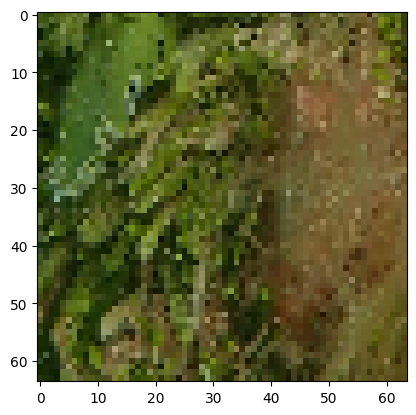

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {1: 0.9991058, 33: 0.00089416985}
Example =  2


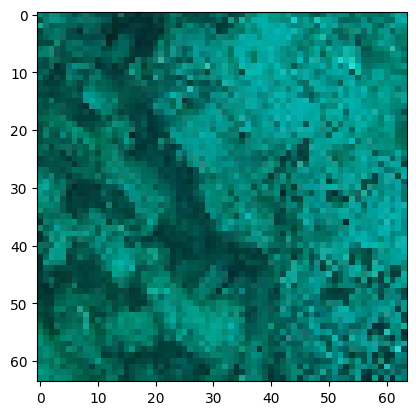

Coarse = {0: 0.046058, 1: 0.953942}
Medium = {7: 0.046058, 9: 0.953942}
Fine   = {33: 0.046058, 37: 0.953942}
Example =  3


In [7]:
for x,y in dataset.train_dataset.take(1):
    for i in range(len(x)):
        print('Example = ', i)
        plt.imshow(x[i])
        plt.show()
        print('Coarse =', {k:v for k,v in enumerate(y[0][i].numpy()) if v != 0}) # coarse lables
        print('Medium =', {k:v for k,v in enumerate(y[1][i].numpy()) if v != 0}) # medium lables
        print('Fine   =', {k:v for k,v in enumerate(y[2][i].numpy()) if v != 0}) # fine lables

In [8]:
for x,y in dataset.train_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

2023-05-11 14:01:13.948008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6183 of 6400
2023-05-11 14:01:14.229358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


## Learning Rate Decay Scheduler

In [9]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [10]:
coarse_class, medium_class, fine_class = dataset.num_classes

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [11]:
Matrix_coarse_to_medium_OneHot = dataset.Matrix_coarse_to_medium_OneHot
Matrix_medium_to_fine_OneHot = dataset.Matrix_medium_to_fine_OneHot

In [12]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [13]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_without_skip(input_shape     = image_shape, 
                                            input_shape_yc  = coarse_label_shape,
                                            input_shape_ym  = medium_label_shape,
                                            input_shape_yf  = fine_label_shape, 
                                            no_coarse_class = coarse_class, 
                                            no_medium_class = medium_class, 
                                            no_fine_class   = fine_class,
                                            PCap_n_dims     = 8, 
                                            SCap_f_dims     = 16, 
                                            SCap_m_dims     = 32, 
                                            SCap_c_dims     = 64
                                            )
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = medium_class, 
                              number_of_classes_f = fine_class, 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [14]:
# strategy = models.multi_gpu_select('windows')
strategy = models.multi_gpu_select('linux')

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [15]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 38)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 38)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 38)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Training Pipeline Alignment

In [16]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = dataset.train_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = dataset.val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'/tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

2023-05-11 14:01:31.865874: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_8"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
input: "Placeholder/_4"
input: "Placeholder/_5"
input: "Placeholder/_6"
input: "Placeholder/_7"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 118260
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = nccl, num_packs = 1


2023-05-11 14:02:51.933924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5889 of 6400
2023-05-11 14:02:52.544674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 14:03:02.655599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4171 of 6400
2023-05-11 14:03:06.086594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 14:03:13.085146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-11 14:03:14.612618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-11 14:03:19.964324: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-11 14:03:34.502544: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f10291eda70 

1848/1848 [==============================] - ETA: 0s - loss: 0.3167 - prediction_coarse_accuracy: 0.7488 - prediction_medium_accuracy: 0.7125 - prediction_fine_accuracy: 0.3624

2023-05-11 14:12:21.454718: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_8"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
input: "Placeholder/_4"
input: "Placeholder/_5"
input: "Placeholder/_6"
input: "Placeholder/_7"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 16127
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:16"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }



  • Coarse Accuracy = 74.88% | Val_Accuracy = 65.77% | LossWeight = 0.39 
  • Medium Accuracy = 71.25% | Val_Accuracy = 72.20% | LossWeight = 0.37 
  • Fine   Accuracy = 36.24% | Val_Accuracy = 43.20% | LossWeight = 0.25 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.43201, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_2_9/epoch-best.h5
1848/1848 [==============================] - 802s 358ms/step - loss: 0.3167 - prediction_coarse_accuracy: 0.7488 - prediction_medium_accuracy: 0.7125 - prediction_fine_accuracy: 0.3624 - val_loss: 0.3033 - val_prediction_coarse_accuracy: 0.6577 - val_prediction_medium_accuracy: 0.7220 - val_prediction_fine_accuracy: 0.4320 - lr: 0.0010
Epoch 2/100


2023-05-11 14:15:14.520689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5921 of 6400
2023-05-11 14:15:15.028209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 14:15:25.154628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3364 of 6400
2023-05-11 14:15:29.658980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2623 - prediction_coarse_accuracy: 0.8570 - prediction_medium_accuracy: 0.7354 - prediction_fine_accuracy: 0.4377
  • Coarse Accuracy = 85.70% | Val_Accuracy = 85.84% | LossWeight = 0.28 
  • Medium Accuracy = 73.54% | Val_Accuracy = 74.92% | LossWeight = 0.44 
  • Fine   Accuracy = 43.77% | Val_Accuracy = 46.56% | LossWeight = 0.28 

Epoch 2: val_prediction_fine_accuracy improved from 0.43201 to 0.46562, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_2_9/epoch-best.h5
1848/1848 [==============================] - 320s 159ms/step - loss: 0.2623 - prediction_coarse_accuracy: 0.8570 - prediction_medium_accuracy: 0.7354 - prediction_fine_accuracy: 0.4377 - val_loss: 0.2547 - val_prediction_coarse_accuracy: 0.8584 - val_prediction_medium_accuracy: 0.7492 - val_prediction_fine_accuracy: 0.4656 - lr: 0.0010
Epoch 3/100
1848/1848 [==============================] - ETA: 0s - loss: 0.2154 - prediction_coarse_accuracy: 0.8573

2023-05-11 14:49:19.894227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6305 of 6400
2023-05-11 14:49:20.042075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 14:49:30.131312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3892 of 6400
2023-05-11 14:49:33.917206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2185 - prediction_coarse_accuracy: 0.8579 - prediction_medium_accuracy: 0.8130 - prediction_fine_accuracy: 0.5356
  • Coarse Accuracy = 85.79% | Val_Accuracy = 85.84% | LossWeight = 0.34 
  • Medium Accuracy = 81.30% | Val_Accuracy = 79.09% | LossWeight = 0.38 
  • Fine   Accuracy = 53.56% | Val_Accuracy = 53.18% | LossWeight = 0.28 

Epoch 8: val_prediction_fine_accuracy improved from 0.51770 to 0.53184, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_2_9/epoch-best.h5
1848/1848 [==============================] - 345s 173ms/step - loss: 0.2185 - prediction_coarse_accuracy: 0.8579 - prediction_medium_accuracy: 0.8130 - prediction_fine_accuracy: 0.5356 - val_loss: 0.2192 - val_prediction_coarse_accuracy: 0.8584 - val_prediction_medium_accuracy: 0.7909 - val_prediction_fine_accuracy: 0.5318 - lr: 0.0010
Epoch 9/100
1848/1848 [==============================] - ETA: 0s - loss: 0.2206 - prediction_coarse_accuracy: 0.8600

2023-05-11 15:15:16.115965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6278 of 6400
2023-05-11 15:15:16.307792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2212 - prediction_coarse_accuracy: 0.8625 - prediction_medium_accuracy: 0.8724 - prediction_fine_accuracy: 0.5946
  • Coarse Accuracy = 86.25% | Val_Accuracy = 86.76% | LossWeight = 0.40 
  • Medium Accuracy = 87.24% | Val_Accuracy = 78.89% | LossWeight = 0.31 
  • Fine   Accuracy = 59.46% | Val_Accuracy = 53.87% | LossWeight = 0.29 

Epoch 12: val_prediction_fine_accuracy improved from 0.53581 to 0.53866, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_2_9/epoch-best.h5
1848/1848 [==============================] - 332s 169ms/step - loss: 0.2212 - prediction_coarse_accuracy: 0.8625 - prediction_medium_accuracy: 0.8724 - prediction_fine_accuracy: 0.5946 - val_loss: 0.2386 - val_prediction_coarse_accuracy: 0.8676 - val_prediction_medium_accuracy: 0.7889 - val_prediction_fine_accuracy: 0.5387 - lr: 9.0250e-04
Epoch 13/100


2023-05-11 15:21:39.737436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5746 of 6400
2023-05-11 15:21:40.690579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2271 - prediction_coarse_accuracy: 0.8676 - prediction_medium_accuracy: 0.8852 - prediction_fine_accuracy: 0.6073
  • Coarse Accuracy = 86.76% | Val_Accuracy = 87.16% | LossWeight = 0.41 
  • Medium Accuracy = 88.52% | Val_Accuracy = 77.76% | LossWeight = 0.29 
  • Fine   Accuracy = 60.73% | Val_Accuracy = 53.97% | LossWeight = 0.30 

Epoch 13: val_prediction_fine_accuracy improved from 0.53866 to 0.53965, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_2_9/epoch-best.h5
1848/1848 [==============================] - 355s 181ms/step - loss: 0.2271 - prediction_coarse_accuracy: 0.8676 - prediction_medium_accuracy: 0.8852 - prediction_fine_accuracy: 0.6073 - val_loss: 0.2531 - val_prediction_coarse_accuracy: 0.8716 - val_prediction_medium_accuracy: 0.7776 - val_prediction_fine_accuracy: 0.5397 - lr: 8.5737e-04
Epoch 14/100


2023-05-11 15:27:35.986774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6145 of 6400
2023-05-11 15:27:36.329974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2262 - prediction_coarse_accuracy: 0.8682 - prediction_medium_accuracy: 0.8997 - prediction_fine_accuracy: 0.6222
  • Coarse Accuracy = 86.82% | Val_Accuracy = 86.62% | LossWeight = 0.43 
  • Medium Accuracy = 89.97% | Val_Accuracy = 77.08% | LossWeight = 0.27 
  • Fine   Accuracy = 62.22% | Val_Accuracy = 53.58% | LossWeight = 0.30 

Epoch 14: val_prediction_fine_accuracy did not improve from 0.53965
1848/1848 [==============================] - 347s 177ms/step - loss: 0.2262 - prediction_coarse_accuracy: 0.8682 - prediction_medium_accuracy: 0.8997 - prediction_fine_accuracy: 0.6222 - val_loss: 0.2598 - val_prediction_coarse_accuracy: 0.8662 - val_prediction_medium_accuracy: 0.7708 - val_prediction_fine_accuracy: 0.5358 - lr: 8.1451e-04
Epoch 15/100


2023-05-11 15:33:15.646228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5893 of 6400
2023-05-11 15:33:16.344517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 15:33:26.440089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4171 of 6400
2023-05-11 15:33:29.719209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2308 - prediction_coarse_accuracy: 0.8655 - prediction_medium_accuracy: 0.9112 - prediction_fine_accuracy: 0.6377
  • Coarse Accuracy = 86.55% | Val_Accuracy = 86.86% | LossWeight = 0.45 
  • Medium Accuracy = 91.12% | Val_Accuracy = 77.59% | LossWeight = 0.25 
  • Fine   Accuracy = 63.77% | Val_Accuracy = 54.72% | LossWeight = 0.30 

Epoch 15: val_prediction_fine_accuracy improved from 0.53965 to 0.54716, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_2_9/epoch-best.h5
1848/1848 [==============================] - 345s 173ms/step - loss: 0.2308 - prediction_coarse_accuracy: 0.8655 - prediction_medium_accuracy: 0.9112 - prediction_fine_accuracy: 0.6377 - val_loss: 0.2672 - val_prediction_coarse_accuracy: 0.8686 - val_prediction_medium_accuracy: 0.7759 - val_prediction_fine_accuracy: 0.5472 - lr: 7.7378e-04
Epoch 16/100
1848/1848 [==============================] - ETA: 0s - loss: 0.2383 - prediction_coarse_accuracy: 

2023-05-11 16:19:10.338385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6116 of 6400
2023-05-11 16:19:10.778552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2554 - prediction_coarse_accuracy: 0.8692 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.7216
  • Coarse Accuracy = 86.92% | Val_Accuracy = 86.98% | LossWeight = 0.54 
  • Medium Accuracy = 94.82% | Val_Accuracy = 78.15% | LossWeight = 0.18 
  • Fine   Accuracy = 72.16% | Val_Accuracy = 54.91% | LossWeight = 0.29 

Epoch 22: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 341s 174ms/step - loss: 0.2554 - prediction_coarse_accuracy: 0.8692 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.7216 - val_loss: 0.3037 - val_prediction_coarse_accuracy: 0.8698 - val_prediction_medium_accuracy: 0.7815 - val_prediction_fine_accuracy: 0.5491 - lr: 5.4036e-04
Epoch 23/100


2023-05-11 16:25:23.768603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6277 of 6400
2023-05-11 16:25:23.954239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 16:25:34.068212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4246 of 6400
2023-05-11 16:25:37.615721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2612 - prediction_coarse_accuracy: 0.8711 - prediction_medium_accuracy: 0.9512 - prediction_fine_accuracy: 0.7338
  • Coarse Accuracy = 87.11% | Val_Accuracy = 87.47% | LossWeight = 0.55 
  • Medium Accuracy = 95.12% | Val_Accuracy = 78.13% | LossWeight = 0.17 
  • Fine   Accuracy = 73.38% | Val_Accuracy = 54.68% | LossWeight = 0.28 

Epoch 23: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 345s 174ms/step - loss: 0.2612 - prediction_coarse_accuracy: 0.8711 - prediction_medium_accuracy: 0.9512 - prediction_fine_accuracy: 0.7338 - val_loss: 0.3107 - val_prediction_coarse_accuracy: 0.8747 - val_prediction_medium_accuracy: 0.7813 - val_prediction_fine_accuracy: 0.5468 - lr: 5.1334e-04
Epoch 24/100


2023-05-11 16:31:19.985760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5978 of 6400
2023-05-11 16:31:20.482843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2637 - prediction_coarse_accuracy: 0.8697 - prediction_medium_accuracy: 0.9525 - prediction_fine_accuracy: 0.7446
  • Coarse Accuracy = 86.97% | Val_Accuracy = 86.49% | LossWeight = 0.56 
  • Medium Accuracy = 95.25% | Val_Accuracy = 76.59% | LossWeight = 0.17 
  • Fine   Accuracy = 74.46% | Val_Accuracy = 53.46% | LossWeight = 0.27 

Epoch 24: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 360s 184ms/step - loss: 0.2637 - prediction_coarse_accuracy: 0.8697 - prediction_medium_accuracy: 0.9525 - prediction_fine_accuracy: 0.7446 - val_loss: 0.3227 - val_prediction_coarse_accuracy: 0.8649 - val_prediction_medium_accuracy: 0.7659 - val_prediction_fine_accuracy: 0.5346 - lr: 4.8767e-04
Epoch 25/100


2023-05-11 16:37:41.045238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6124 of 6400
2023-05-11 16:37:41.480534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2672 - prediction_coarse_accuracy: 0.8681 - prediction_medium_accuracy: 0.9542 - prediction_fine_accuracy: 0.7550
  • Coarse Accuracy = 86.81% | Val_Accuracy = 86.77% | LossWeight = 0.57 
  • Medium Accuracy = 95.42% | Val_Accuracy = 78.77% | LossWeight = 0.17 
  • Fine   Accuracy = 75.50% | Val_Accuracy = 54.45% | LossWeight = 0.26 

Epoch 25: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 437s 226ms/step - loss: 0.2672 - prediction_coarse_accuracy: 0.8681 - prediction_medium_accuracy: 0.9542 - prediction_fine_accuracy: 0.7550 - val_loss: 0.3172 - val_prediction_coarse_accuracy: 0.8677 - val_prediction_medium_accuracy: 0.7877 - val_prediction_fine_accuracy: 0.5445 - lr: 4.6329e-04
Epoch 26/100


2023-05-11 16:45:04.738142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6173 of 6400
2023-05-11 16:45:05.010795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2712 - prediction_coarse_accuracy: 0.8705 - prediction_medium_accuracy: 0.9568 - prediction_fine_accuracy: 0.7668
  • Coarse Accuracy = 87.05% | Val_Accuracy = 86.84% | LossWeight = 0.58 
  • Medium Accuracy = 95.68% | Val_Accuracy = 78.47% | LossWeight = 0.16 
  • Fine   Accuracy = 76.68% | Val_Accuracy = 54.69% | LossWeight = 0.26 

Epoch 26: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 354s 181ms/step - loss: 0.2712 - prediction_coarse_accuracy: 0.8705 - prediction_medium_accuracy: 0.9568 - prediction_fine_accuracy: 0.7668 - val_loss: 0.3236 - val_prediction_coarse_accuracy: 0.8684 - val_prediction_medium_accuracy: 0.7847 - val_prediction_fine_accuracy: 0.5469 - lr: 4.4013e-04
Epoch 27/100
1848/1848 [==============================] - ETA: 0s - loss: 0.2738 - prediction_coarse_accuracy: 0.8697 - prediction_medium_accuracy: 0.9581 - prediction_fine_accuracy: 0.7781


2023-05-11 17:10:01.301515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6157 of 6400
2023-05-11 17:10:01.597249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2834 - prediction_coarse_accuracy: 0.8690 - prediction_medium_accuracy: 0.9607 - prediction_fine_accuracy: 0.8058
  • Coarse Accuracy = 86.90% | Val_Accuracy = 87.18% | LossWeight = 0.62 
  • Medium Accuracy = 96.07% | Val_Accuracy = 78.69% | LossWeight = 0.15 
  • Fine   Accuracy = 80.58% | Val_Accuracy = 54.35% | LossWeight = 0.23 

Epoch 30: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 345s 176ms/step - loss: 0.2834 - prediction_coarse_accuracy: 0.8690 - prediction_medium_accuracy: 0.9607 - prediction_fine_accuracy: 0.8058 - val_loss: 0.3392 - val_prediction_coarse_accuracy: 0.8718 - val_prediction_medium_accuracy: 0.7869 - val_prediction_fine_accuracy: 0.5435 - lr: 3.5849e-04
Epoch 31/100
1848/1848 [==============================] - ETA: 0s - loss: 0.2860 - prediction_coarse_accuracy: 0.8688 - prediction_medium_accuracy: 0.9621 - prediction_fine_accuracy: 0.8139


2023-05-11 17:30:24.601405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1622 of 6400
2023-05-11 17:30:34.633436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3411 of 6400
2023-05-11 17:30:44.603666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5148 of 6400
2023-05-11 17:30:46.298340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 17:30:56.481647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4171 of 6400
2023-05-11 17:30:59.295530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2899 - prediction_coarse_accuracy: 0.8687 - prediction_medium_accuracy: 0.9617 - prediction_fine_accuracy: 0.8262
  • Coarse Accuracy = 86.87% | Val_Accuracy = 86.87% | LossWeight = 0.64 
  • Medium Accuracy = 96.17% | Val_Accuracy = 78.40% | LossWeight = 0.15 
  • Fine   Accuracy = 82.62% | Val_Accuracy = 53.78% | LossWeight = 0.21 

Epoch 33: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 358s 170ms/step - loss: 0.2899 - prediction_coarse_accuracy: 0.8687 - prediction_medium_accuracy: 0.9617 - prediction_fine_accuracy: 0.8262 - val_loss: 0.3485 - val_prediction_coarse_accuracy: 0.8687 - val_prediction_medium_accuracy: 0.7840 - val_prediction_fine_accuracy: 0.5378 - lr: 3.0736e-04
Epoch 34/100


2023-05-11 17:36:56.287324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5794 of 6400
2023-05-11 17:36:57.084937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2919 - prediction_coarse_accuracy: 0.8694 - prediction_medium_accuracy: 0.9630 - prediction_fine_accuracy: 0.8328
  • Coarse Accuracy = 86.94% | Val_Accuracy = 86.79% | LossWeight = 0.64 
  • Medium Accuracy = 96.30% | Val_Accuracy = 78.87% | LossWeight = 0.15 
  • Fine   Accuracy = 83.28% | Val_Accuracy = 53.91% | LossWeight = 0.21 

Epoch 34: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 341s 173ms/step - loss: 0.2919 - prediction_coarse_accuracy: 0.8694 - prediction_medium_accuracy: 0.9630 - prediction_fine_accuracy: 0.8328 - val_loss: 0.3504 - val_prediction_coarse_accuracy: 0.8679 - val_prediction_medium_accuracy: 0.7887 - val_prediction_fine_accuracy: 0.5391 - lr: 2.9199e-04
Epoch 35/100


2023-05-11 17:42:29.322269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6192 of 6400
2023-05-11 17:42:29.663258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 17:42:39.918042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3880 of 6400
2023-05-11 17:42:43.426000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.2943 - prediction_coarse_accuracy: 0.8688 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.8372
  • Coarse Accuracy = 86.88% | Val_Accuracy = 86.97% | LossWeight = 0.65 
  • Medium Accuracy = 96.28% | Val_Accuracy = 79.02% | LossWeight = 0.15 
  • Fine   Accuracy = 83.72% | Val_Accuracy = 54.08% | LossWeight = 0.20 

Epoch 35: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 342s 172ms/step - loss: 0.2943 - prediction_coarse_accuracy: 0.8688 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.8372 - val_loss: 0.3528 - val_prediction_coarse_accuracy: 0.8697 - val_prediction_medium_accuracy: 0.7902 - val_prediction_fine_accuracy: 0.5408 - lr: 2.7739e-04
Epoch 36/100
1848/1848 [==============================] - ETA: 0s - loss: 0.2952 - prediction_coarse_accuracy: 0.8715 - prediction_medium_accuracy: 0.9651 - prediction_fine_accuracy: 0.8447


2023-05-11 18:06:23.769826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6191 of 6400
2023-05-11 18:06:24.068936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 18:06:34.258871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3660 of 6400
2023-05-11 18:06:38.102390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1675/1848 [==========================>...] - ETA: 24s - loss: 0.3016 - prediction_coarse_accuracy: 0.8673 - prediction_medium_accuracy: 0.9646 - prediction_fine_accuracy: 0.8540

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1848/1848 [==============================] - ETA: 0s - loss: 0.3031 - prediction_coarse_accuracy: 0.8687 - prediction_medium_accuracy: 0.9646 - prediction_fine_accuracy: 0.8578
  • Coarse Accuracy = 86.87% | Val_Accuracy = 86.87% | LossWeight = 0.67 
  • Medium Accuracy = 96.46% | Val_Accuracy = 79.12% | LossWeight = 0.15 
  • Fine   Accuracy = 85.78% | Val_Accuracy = 54.02% | LossWeight = 0.18 

Epoch 40: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 302s 151ms/step - loss: 0.3031 - prediction_coarse_accuracy: 0.8687 - prediction_medium_accuracy: 0.9646 - prediction_fine_accuracy: 0.8578 - val_loss: 0.3640 - val_prediction_coarse_accuracy: 0.8687 - val_prediction_medium_accuracy: 0.7912 - val_prediction_fine_accuracy: 0.5402 - lr: 2.1464e-04
Epoch 41/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3027 - prediction_coarse_accuracy: 0.8690 - prediction_medium_accuracy: 0.9660 - prediction_fine_accuracy: 0.8629


2023-05-11 18:23:20.494925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5674 of 6400
2023-05-11 18:23:21.707862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3057 - prediction_coarse_accuracy: 0.8682 - prediction_medium_accuracy: 0.9654 - prediction_fine_accuracy: 0.8649
  • Coarse Accuracy = 86.82% | Val_Accuracy = 86.69% | LossWeight = 0.68 
  • Medium Accuracy = 96.54% | Val_Accuracy = 79.12% | LossWeight = 0.15 
  • Fine   Accuracy = 86.49% | Val_Accuracy = 53.66% | LossWeight = 0.17 

Epoch 42: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 338s 172ms/step - loss: 0.3057 - prediction_coarse_accuracy: 0.8682 - prediction_medium_accuracy: 0.9654 - prediction_fine_accuracy: 0.8649 - val_loss: 0.3663 - val_prediction_coarse_accuracy: 0.8669 - val_prediction_medium_accuracy: 0.7912 - val_prediction_fine_accuracy: 0.5366 - lr: 1.9371e-04
Epoch 43/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3058 - prediction_coarse_accuracy: 0.8666 - prediction_medium_accuracy: 0.9668 - prediction_fine_accuracy: 0.8683


2023-05-11 18:34:51.172524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6365 of 6400
2023-05-11 18:34:51.299828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 18:35:01.461893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3967 of 6400
2023-05-11 18:35:05.743844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3095 - prediction_coarse_accuracy: 0.8664 - prediction_medium_accuracy: 0.9661 - prediction_fine_accuracy: 0.8698
  • Coarse Accuracy = 86.64% | Val_Accuracy = 86.43% | LossWeight = 0.69 
  • Medium Accuracy = 96.61% | Val_Accuracy = 79.18% | LossWeight = 0.15 
  • Fine   Accuracy = 86.98% | Val_Accuracy = 53.72% | LossWeight = 0.17 

Epoch 44: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 440s 224ms/step - loss: 0.3095 - prediction_coarse_accuracy: 0.8664 - prediction_medium_accuracy: 0.9661 - prediction_fine_accuracy: 0.8698 - val_loss: 0.3703 - val_prediction_coarse_accuracy: 0.8643 - val_prediction_medium_accuracy: 0.7918 - val_prediction_fine_accuracy: 0.5372 - lr: 1.7482e-04
Epoch 45/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3093 - prediction_coarse_accuracy: 0.8656 - prediction_medium_accuracy: 0.9666 - prediction_fine_accuracy: 0.8720


2023-05-11 18:54:26.315290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5743 of 6400
2023-05-11 18:54:27.600698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3131 - prediction_coarse_accuracy: 0.8643 - prediction_medium_accuracy: 0.9669 - prediction_fine_accuracy: 0.8773
  • Coarse Accuracy = 86.43% | Val_Accuracy = 86.40% | LossWeight = 0.70 
  • Medium Accuracy = 96.69% | Val_Accuracy = 78.46% | LossWeight = 0.14 
  • Fine   Accuracy = 87.73% | Val_Accuracy = 53.77% | LossWeight = 0.16 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 334s 170ms/step - loss: 0.3131 - prediction_coarse_accuracy: 0.8643 - prediction_medium_accuracy: 0.9669 - prediction_fine_accuracy: 0.8773 - val_loss: 0.3764 - val_prediction_coarse_accuracy: 0.8640 - val_prediction_medium_accuracy: 0.7846 - val_prediction_fine_accuracy: 0.5377 - lr: 1.4989e-04
Epoch 48/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3136 - prediction_coarse_accuracy: 0.8655 - prediction_medium_accuracy: 0.9673 - prediction_fine_accuracy: 0.8801


2023-05-11 19:06:29.043625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6268 of 6400
2023-05-11 19:06:29.229191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 19:06:39.334908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3975 of 6400
2023-05-11 19:06:42.793281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3145 - prediction_coarse_accuracy: 0.8632 - prediction_medium_accuracy: 0.9661 - prediction_fine_accuracy: 0.8811
  • Coarse Accuracy = 86.32% | Val_Accuracy = 86.45% | LossWeight = 0.70 
  • Medium Accuracy = 96.61% | Val_Accuracy = 78.76% | LossWeight = 0.14 
  • Fine   Accuracy = 88.11% | Val_Accuracy = 53.96% | LossWeight = 0.15 

Epoch 49: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 343s 172ms/step - loss: 0.3145 - prediction_coarse_accuracy: 0.8632 - prediction_medium_accuracy: 0.9661 - prediction_fine_accuracy: 0.8811 - val_loss: 0.3768 - val_prediction_coarse_accuracy: 0.8645 - val_prediction_medium_accuracy: 0.7876 - val_prediction_fine_accuracy: 0.5396 - lr: 1.3528e-04
Epoch 50/100


2023-05-11 19:13:01.301690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6326 of 6400
2023-05-11 19:13:01.392710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3146 - prediction_coarse_accuracy: 0.8651 - prediction_medium_accuracy: 0.9674 - prediction_fine_accuracy: 0.8830
  • Coarse Accuracy = 86.51% | Val_Accuracy = 86.46% | LossWeight = 0.71 
  • Medium Accuracy = 96.74% | Val_Accuracy = 79.04% | LossWeight = 0.14 
  • Fine   Accuracy = 88.30% | Val_Accuracy = 53.88% | LossWeight = 0.15 

Epoch 50: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 343s 175ms/step - loss: 0.3146 - prediction_coarse_accuracy: 0.8651 - prediction_medium_accuracy: 0.9674 - prediction_fine_accuracy: 0.8830 - val_loss: 0.3767 - val_prediction_coarse_accuracy: 0.8646 - val_prediction_medium_accuracy: 0.7904 - val_prediction_fine_accuracy: 0.5388 - lr: 1.2851e-04
Epoch 51/100


2023-05-11 19:19:14.134444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6183 of 6400
2023-05-11 19:19:14.460809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 19:19:24.648546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3778 of 6400
2023-05-11 19:19:28.566689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3154 - prediction_coarse_accuracy: 0.8647 - prediction_medium_accuracy: 0.9675 - prediction_fine_accuracy: 0.8854
  • Coarse Accuracy = 86.47% | Val_Accuracy = 86.41% | LossWeight = 0.71 
  • Medium Accuracy = 96.75% | Val_Accuracy = 79.08% | LossWeight = 0.14 
  • Fine   Accuracy = 88.54% | Val_Accuracy = 53.95% | LossWeight = 0.15 

Epoch 51: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 448s 229ms/step - loss: 0.3154 - prediction_coarse_accuracy: 0.8647 - prediction_medium_accuracy: 0.9675 - prediction_fine_accuracy: 0.8854 - val_loss: 0.3782 - val_prediction_coarse_accuracy: 0.8641 - val_prediction_medium_accuracy: 0.7908 - val_prediction_fine_accuracy: 0.5395 - lr: 1.2209e-04
Epoch 52/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3166 - prediction_coarse_accuracy: 0.8645 - prediction_medium_accuracy: 0.9678 - prediction_fine_accuracy: 0.8860


2023-05-11 19:52:22.309902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5689 of 6400
2023-05-11 19:52:23.155733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3191 - prediction_coarse_accuracy: 0.8631 - prediction_medium_accuracy: 0.9674 - prediction_fine_accuracy: 0.8918
  • Coarse Accuracy = 86.31% | Val_Accuracy = 86.22% | LossWeight = 0.72 
  • Medium Accuracy = 96.74% | Val_Accuracy = 78.53% | LossWeight = 0.14 
  • Fine   Accuracy = 89.18% | Val_Accuracy = 53.62% | LossWeight = 0.14 

Epoch 56: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 326s 165ms/step - loss: 0.3191 - prediction_coarse_accuracy: 0.8631 - prediction_medium_accuracy: 0.9674 - prediction_fine_accuracy: 0.8918 - val_loss: 0.3839 - val_prediction_coarse_accuracy: 0.8622 - val_prediction_medium_accuracy: 0.7853 - val_prediction_fine_accuracy: 0.5362 - lr: 9.4468e-05
Epoch 57/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3193 - prediction_coarse_accuracy: 0.8612 - prediction_medium_accuracy: 0.9676 - prediction_fine_accuracy: 0.8924


2023-05-11 20:12:21.292519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1810 of 6400
2023-05-11 20:12:31.374732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3817 of 6400
2023-05-11 20:12:41.309626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5465 of 6400
2023-05-11 20:12:46.960940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 20:12:57.424903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5654 of 6400
2023-05-11 20:12:58.787279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3219 - prediction_coarse_accuracy: 0.8612 - prediction_medium_accuracy: 0.9685 - prediction_fine_accuracy: 0.8958
  • Coarse Accuracy = 86.12% | Val_Accuracy = 86.10% | LossWeight = 0.73 
  • Medium Accuracy = 96.85% | Val_Accuracy = 78.79% | LossWeight = 0.14 
  • Fine   Accuracy = 89.58% | Val_Accuracy = 53.66% | LossWeight = 0.14 

Epoch 59: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 427s 205ms/step - loss: 0.3219 - prediction_coarse_accuracy: 0.8612 - prediction_medium_accuracy: 0.9685 - prediction_fine_accuracy: 0.8958 - val_loss: 0.3870 - val_prediction_coarse_accuracy: 0.8610 - val_prediction_medium_accuracy: 0.7879 - val_prediction_fine_accuracy: 0.5366 - lr: 8.0995e-05
Epoch 60/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3230 - prediction_coarse_accuracy: 0.8607 - prediction_medium_accuracy: 0.9688 - prediction_fine_accuracy: 0.8962


2023-05-11 20:25:17.444949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6353 of 6400
2023-05-11 20:25:17.458874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 20:25:27.593233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3880 of 6400
2023-05-11 20:25:31.603506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3237 - prediction_coarse_accuracy: 0.8606 - prediction_medium_accuracy: 0.9690 - prediction_fine_accuracy: 0.8965
  • Coarse Accuracy = 86.06% | Val_Accuracy = 86.07% | LossWeight = 0.73 
  • Medium Accuracy = 96.90% | Val_Accuracy = 78.71% | LossWeight = 0.14 
  • Fine   Accuracy = 89.65% | Val_Accuracy = 53.57% | LossWeight = 0.14 

Epoch 61: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 346s 174ms/step - loss: 0.3237 - prediction_coarse_accuracy: 0.8606 - prediction_medium_accuracy: 0.9690 - prediction_fine_accuracy: 0.8965 - val_loss: 0.3880 - val_prediction_coarse_accuracy: 0.8607 - val_prediction_medium_accuracy: 0.7871 - val_prediction_fine_accuracy: 0.5357 - lr: 7.3098e-05
Epoch 62/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3240 - prediction_coarse_accuracy: 0.8605 - prediction_medium_accuracy: 0.9685 - prediction_fine_accuracy: 0.8979


2023-05-11 20:43:55.442447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6362 of 6400
2023-05-11 20:43:55.504075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3237 - prediction_coarse_accuracy: 0.8611 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.8987
  • Coarse Accuracy = 86.11% | Val_Accuracy = 86.00% | LossWeight = 0.73 
  • Medium Accuracy = 96.83% | Val_Accuracy = 78.83% | LossWeight = 0.14 
  • Fine   Accuracy = 89.87% | Val_Accuracy = 53.48% | LossWeight = 0.13 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 332s 169ms/step - loss: 0.3237 - prediction_coarse_accuracy: 0.8611 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.8987 - val_loss: 0.3876 - val_prediction_coarse_accuracy: 0.8600 - val_prediction_medium_accuracy: 0.7883 - val_prediction_fine_accuracy: 0.5348 - lr: 6.2672e-05
Epoch 65/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3238 - prediction_coarse_accuracy: 0.8613 - prediction_medium_accuracy: 0.9681 - prediction_fine_accuracy: 0.8989


2023-05-11 20:55:50.914536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5992 of 6400
2023-05-11 20:55:51.543610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3233 - prediction_coarse_accuracy: 0.8604 - prediction_medium_accuracy: 0.9681 - prediction_fine_accuracy: 0.8997
  • Coarse Accuracy = 86.04% | Val_Accuracy = 86.00% | LossWeight = 0.73 
  • Medium Accuracy = 96.81% | Val_Accuracy = 78.81% | LossWeight = 0.14 
  • Fine   Accuracy = 89.97% | Val_Accuracy = 53.72% | LossWeight = 0.13 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 443s 229ms/step - loss: 0.3233 - prediction_coarse_accuracy: 0.8604 - prediction_medium_accuracy: 0.9681 - prediction_fine_accuracy: 0.8997 - val_loss: 0.3882 - val_prediction_coarse_accuracy: 0.8600 - val_prediction_medium_accuracy: 0.7881 - val_prediction_fine_accuracy: 0.5372 - lr: 5.6562e-05
Epoch 67/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3239 - prediction_coarse_accuracy: 0.8605 - prediction_medium_accuracy: 0.9696 - prediction_fine_accuracy: 0.9016


2023-05-11 21:34:44.290503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5955 of 6400
2023-05-11 21:34:44.968323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3255 - prediction_coarse_accuracy: 0.8594 - prediction_medium_accuracy: 0.9686 - prediction_fine_accuracy: 0.9026
  • Coarse Accuracy = 85.94% | Val_Accuracy = 86.00% | LossWeight = 0.74 
  • Medium Accuracy = 96.86% | Val_Accuracy = 78.73% | LossWeight = 0.14 
  • Fine   Accuracy = 90.26% | Val_Accuracy = 53.49% | LossWeight = 0.13 

Epoch 72: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 352s 180ms/step - loss: 0.3255 - prediction_coarse_accuracy: 0.8594 - prediction_medium_accuracy: 0.9686 - prediction_fine_accuracy: 0.9026 - val_loss: 0.3902 - val_prediction_coarse_accuracy: 0.8600 - val_prediction_medium_accuracy: 0.7873 - val_prediction_fine_accuracy: 0.5349 - lr: 4.1578e-05
Epoch 73/100


2023-05-11 21:41:06.880806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6079 of 6400
2023-05-11 21:41:07.285663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3258 - prediction_coarse_accuracy: 0.8607 - prediction_medium_accuracy: 0.9684 - prediction_fine_accuracy: 0.9049
  • Coarse Accuracy = 86.07% | Val_Accuracy = 85.97% | LossWeight = 0.74 
  • Medium Accuracy = 96.84% | Val_Accuracy = 78.76% | LossWeight = 0.14 
  • Fine   Accuracy = 90.49% | Val_Accuracy = 53.80% | LossWeight = 0.13 

Epoch 73: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 465s 241ms/step - loss: 0.3258 - prediction_coarse_accuracy: 0.8607 - prediction_medium_accuracy: 0.9684 - prediction_fine_accuracy: 0.9049 - val_loss: 0.3907 - val_prediction_coarse_accuracy: 0.8597 - val_prediction_medium_accuracy: 0.7876 - val_prediction_fine_accuracy: 0.5380 - lr: 3.9499e-05
Epoch 74/100


2023-05-11 21:49:20.200469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1535 of 6400
2023-05-11 21:49:30.222443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6270 of 6400
2023-05-11 21:49:30.456967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 21:49:40.568802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3709 of 6400
2023-05-11 21:49:47.955721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3260 - prediction_coarse_accuracy: 0.8603 - prediction_medium_accuracy: 0.9684 - prediction_fine_accuracy: 0.9044
  • Coarse Accuracy = 86.03% | Val_Accuracy = 85.97% | LossWeight = 0.74 
  • Medium Accuracy = 96.84% | Val_Accuracy = 78.59% | LossWeight = 0.14 
  • Fine   Accuracy = 90.44% | Val_Accuracy = 53.72% | LossWeight = 0.13 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 351s 169ms/step - loss: 0.3260 - prediction_coarse_accuracy: 0.8603 - prediction_medium_accuracy: 0.9684 - prediction_fine_accuracy: 0.9044 - val_loss: 0.3905 - val_prediction_coarse_accuracy: 0.8597 - val_prediction_medium_accuracy: 0.7859 - val_prediction_fine_accuracy: 0.5372 - lr: 3.7524e-05
Epoch 75/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3256 - prediction_coarse_accuracy: 0.8588 - prediction_medium_accuracy: 0.9693 - prediction_fine_accuracy: 0.9058


2023-05-11 22:24:52.112804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6157 of 6400
2023-05-11 22:24:52.439855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3274 - prediction_coarse_accuracy: 0.8592 - prediction_medium_accuracy: 0.9686 - prediction_fine_accuracy: 0.9061
  • Coarse Accuracy = 85.92% | Val_Accuracy = 85.96% | LossWeight = 0.74 
  • Medium Accuracy = 96.86% | Val_Accuracy = 78.46% | LossWeight = 0.14 
  • Fine   Accuracy = 90.61% | Val_Accuracy = 53.33% | LossWeight = 0.12 

Epoch 80: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 308s 156ms/step - loss: 0.3274 - prediction_coarse_accuracy: 0.8592 - prediction_medium_accuracy: 0.9686 - prediction_fine_accuracy: 0.9061 - val_loss: 0.3931 - val_prediction_coarse_accuracy: 0.8596 - val_prediction_medium_accuracy: 0.7846 - val_prediction_fine_accuracy: 0.5333 - lr: 2.7584e-05
Epoch 81/100


2023-05-11 22:30:02.571139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6246 of 6400
2023-05-11 22:30:02.872538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3272 - prediction_coarse_accuracy: 0.8593 - prediction_medium_accuracy: 0.9686 - prediction_fine_accuracy: 0.9066
  • Coarse Accuracy = 85.93% | Val_Accuracy = 85.92% | LossWeight = 0.74 
  • Medium Accuracy = 96.86% | Val_Accuracy = 78.84% | LossWeight = 0.14 
  • Fine   Accuracy = 90.66% | Val_Accuracy = 53.70% | LossWeight = 0.12 

Epoch 81: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 392s 201ms/step - loss: 0.3272 - prediction_coarse_accuracy: 0.8593 - prediction_medium_accuracy: 0.9686 - prediction_fine_accuracy: 0.9066 - val_loss: 0.3919 - val_prediction_coarse_accuracy: 0.8592 - val_prediction_medium_accuracy: 0.7884 - val_prediction_fine_accuracy: 0.5370 - lr: 2.6205e-05
Epoch 82/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3270 - prediction_coarse_accuracy: 0.8584 - prediction_medium_accuracy: 0.9694 - prediction_fine_accuracy: 0.9091


2023-05-11 23:18:48.229100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5810 of 6400
2023-05-11 23:18:48.892344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3276 - prediction_coarse_accuracy: 0.8592 - prediction_medium_accuracy: 0.9700 - prediction_fine_accuracy: 0.9092
  • Coarse Accuracy = 85.92% | Val_Accuracy = 85.89% | LossWeight = 0.75 
  • Medium Accuracy = 97.00% | Val_Accuracy = 78.59% | LossWeight = 0.13 
  • Fine   Accuracy = 90.92% | Val_Accuracy = 53.29% | LossWeight = 0.12 

Epoch 90: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 339s 173ms/step - loss: 0.3276 - prediction_coarse_accuracy: 0.8592 - prediction_medium_accuracy: 0.9700 - prediction_fine_accuracy: 0.9092 - val_loss: 0.3928 - val_prediction_coarse_accuracy: 0.8589 - val_prediction_medium_accuracy: 0.7859 - val_prediction_fine_accuracy: 0.5329 - lr: 1.6515e-05
Epoch 91/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3298 - prediction_coarse_accuracy: 0.8596 - prediction_medium_accuracy: 0.9691 - prediction_fine_accuracy: 0.9086


2023-05-11 23:36:55.050523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1713 of 6400
2023-05-11 23:37:04.983087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3543 of 6400
2023-05-11 23:37:15.024151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5161 of 6400
2023-05-11 23:37:22.698115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 23:37:33.243809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6338 of 6400
2023-05-11 23:37:33.274467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3296 - prediction_coarse_accuracy: 0.8597 - prediction_medium_accuracy: 0.9691 - prediction_fine_accuracy: 0.9094
  • Coarse Accuracy = 85.97% | Val_Accuracy = 85.87% | LossWeight = 0.74 
  • Medium Accuracy = 96.91% | Val_Accuracy = 78.59% | LossWeight = 0.14 
  • Fine   Accuracy = 90.94% | Val_Accuracy = 53.23% | LossWeight = 0.12 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 370s 174ms/step - loss: 0.3296 - prediction_coarse_accuracy: 0.8597 - prediction_medium_accuracy: 0.9691 - prediction_fine_accuracy: 0.9094 - val_loss: 0.3951 - val_prediction_coarse_accuracy: 0.8587 - val_prediction_medium_accuracy: 0.7859 - val_prediction_fine_accuracy: 0.5323 - lr: 1.4160e-05
Epoch 94/100


2023-05-11 23:43:17.260423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6253 of 6400
2023-05-11 23:43:17.474751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 23:43:27.816191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4094 of 6400
2023-05-11 23:43:30.837249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3281 - prediction_coarse_accuracy: 0.8590 - prediction_medium_accuracy: 0.9699 - prediction_fine_accuracy: 0.9096
  • Coarse Accuracy = 85.90% | Val_Accuracy = 85.87% | LossWeight = 0.75 
  • Medium Accuracy = 96.99% | Val_Accuracy = 78.60% | LossWeight = 0.13 
  • Fine   Accuracy = 90.96% | Val_Accuracy = 53.34% | LossWeight = 0.12 

Epoch 94: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 321s 161ms/step - loss: 0.3281 - prediction_coarse_accuracy: 0.8590 - prediction_medium_accuracy: 0.9699 - prediction_fine_accuracy: 0.9096 - val_loss: 0.3937 - val_prediction_coarse_accuracy: 0.8587 - val_prediction_medium_accuracy: 0.7860 - val_prediction_fine_accuracy: 0.5334 - lr: 1.3452e-05
Epoch 95/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3294 - prediction_coarse_accuracy: 0.8583 - prediction_medium_accuracy: 0.9705 - prediction_fine_accuracy: 0.9097


2023-05-11 23:56:02.057123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6360 of 6400
2023-05-11 23:56:02.117201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-11 23:56:12.257880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4303 of 6400
2023-05-11 23:56:15.932686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3310 - prediction_coarse_accuracy: 0.8582 - prediction_medium_accuracy: 0.9698 - prediction_fine_accuracy: 0.9095
  • Coarse Accuracy = 85.82% | Val_Accuracy = 85.87% | LossWeight = 0.75 
  • Medium Accuracy = 96.98% | Val_Accuracy = 78.67% | LossWeight = 0.13 
  • Fine   Accuracy = 90.95% | Val_Accuracy = 53.28% | LossWeight = 0.12 

Epoch 96: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 378s 191ms/step - loss: 0.3310 - prediction_coarse_accuracy: 0.8582 - prediction_medium_accuracy: 0.9698 - prediction_fine_accuracy: 0.9095 - val_loss: 0.3963 - val_prediction_coarse_accuracy: 0.8587 - val_prediction_medium_accuracy: 0.7867 - val_prediction_fine_accuracy: 0.5328 - lr: 1.2140e-05
Epoch 97/100


2023-05-12 00:02:24.816810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4898 of 6400
2023-05-12 00:02:27.696236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-12 00:02:37.902159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4711 of 6400
2023-05-12 00:02:39.782333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.3299 - prediction_coarse_accuracy: 0.8583 - prediction_medium_accuracy: 0.9694 - prediction_fine_accuracy: 0.9092
  • Coarse Accuracy = 85.83% | Val_Accuracy = 85.87% | LossWeight = 0.75 
  • Medium Accuracy = 96.94% | Val_Accuracy = 78.65% | LossWeight = 0.13 
  • Fine   Accuracy = 90.92% | Val_Accuracy = 53.27% | LossWeight = 0.12 

Epoch 97: val_prediction_fine_accuracy did not improve from 0.55720
1848/1848 [==============================] - 540s 278ms/step - loss: 0.3299 - prediction_coarse_accuracy: 0.8583 - prediction_medium_accuracy: 0.9694 - prediction_fine_accuracy: 0.9092 - val_loss: 0.3953 - val_prediction_coarse_accuracy: 0.8587 - val_prediction_medium_accuracy: 0.7865 - val_prediction_fine_accuracy: 0.5327 - lr: 1.1533e-05
Epoch 98/100
1848/1848 [==============================] - ETA: 0s - loss: 0.3293 - prediction_coarse_accuracy: 0.8587 - prediction_medium_accuracy: 0.9696 - prediction_fine_accuracy: 0.9082


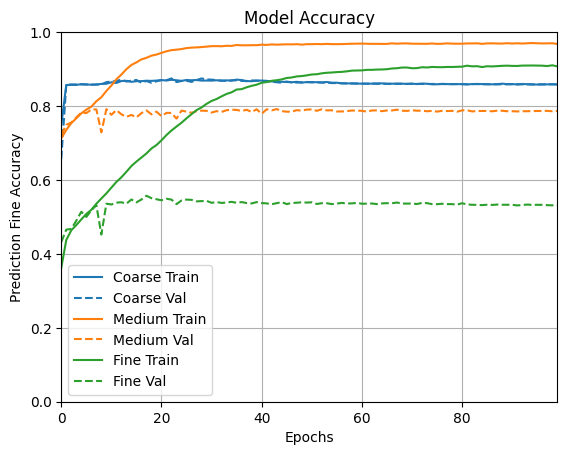

In [19]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

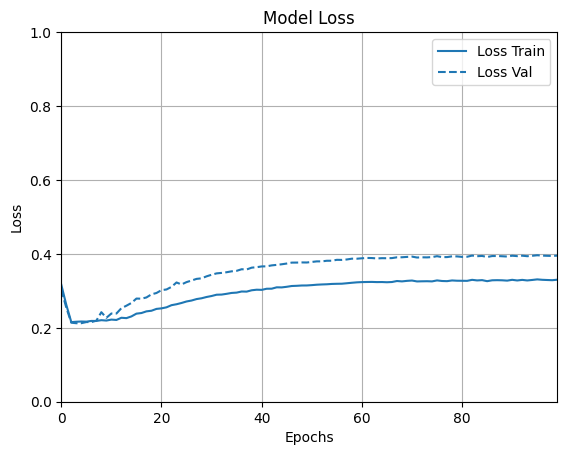

In [20]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [21]:
final_model = keras.Model(model.inputs[:1], model.output)
final_model.load_weights(directory+'/epoch-best.h5')

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [22]:
results = final_model.evaluate(dataset.test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
# model_predictions = final_model.predict(dataset.test_dataset)

419/419 [==============================] - 189s 420ms/step - loss: 0.3648 - prediction_coarse_loss: 0.4047 - prediction_medium_loss: 0.1761 - prediction_fine_loss: 0.3374 - prediction_coarse_accuracy: 0.8698 - prediction_medium_accuracy: 0.7782 - prediction_fine_accuracy: 0.5504
1. loss ==> 0.364770770072937
2. prediction_coarse_loss ==> 0.40472298860549927
3. prediction_medium_loss ==> 0.17612215876579285
4. prediction_fine_loss ==> 0.33743903040885925
5. prediction_coarse_accuracy ==> 0.8697664141654968
6. prediction_medium_accuracy ==> 0.778192400932312
7. prediction_fine_accuracy ==> 0.5503768920898438


In [23]:
def predict_from_pipeline(model, dataset):
    y_pred_c = []
    y_pred_m = []
    y_pred_f = []
    
    y_true_c = []
    y_true_m = []
    y_true_f = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        
        y_true_c.extend(y[0].numpy().tolist())
        y_true_m.extend(y[1].numpy().tolist())
        y_true_f.extend(y[2].numpy().tolist())
        
        y_pred_c.extend(batch_pred[0].tolist())
        y_pred_m.extend(batch_pred[1].tolist())
        y_pred_f.extend(batch_pred[2].tolist())
        
    return np.array(y_true_c), np.array(y_true_m), np.array(y_true_f), np.array(y_pred_c), np.array(y_pred_m), np.array(y_pred_f)

In [24]:
y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f = predict_from_pipeline(final_model, dataset.test_dataset)

2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 4s 948ms/step


  • Confusion_Matrix 

  • COARSE LEVEL 
[[22967   113]
 [ 3377   341]]

  • MEDIUM LEVEL 
[[   71    75     0     0     1     7     5   509     0    75]
 [   57  1174     0     0     0     6     5   930     0   153]
 [    0     0     0     0     0     0     0    23     0     1]
 [    7     9     0    22     0     1     1    70     0     9]
 [    2     1     0     0     0     0     0    46     0     0]
 [   10    15     0     1     0     7     1    90     0    20]
 [    1     4     0     0     0     0   408   263     0    19]
 [  125   518     0     9     6    24   138 17247     1   894]
 [    0     1     0     0     0     0     0    16     0     2]
 [   33   181     0     4     0     6    17  1552     0  1925]]

  • FINE LEVEL 
[[347  20   0 ...   0   9   4]
 [ 44 136   0 ...   0   3   0]
 [ 23  50   0 ...   0   5   1]
 ...
 [  8   9   0 ...   0   2   0]
 [ 48  10   0 ...   0  23   2]
 [  4   0   0 ...   0   0 213]]

  • Classification Report 


  • COARSE LEVEL 


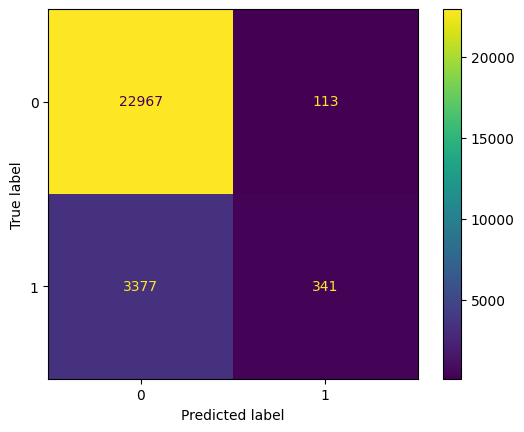

              precision    recall  f1-score   support

           0    0.87181   0.99510   0.92939     23080
           1    0.75110   0.09172   0.16347      3718

    accuracy                        0.86977     26798
   macro avg    0.81146   0.54341   0.54643     26798
weighted avg    0.85506   0.86977   0.82312     26798


  • MEDIUM LEVEL 


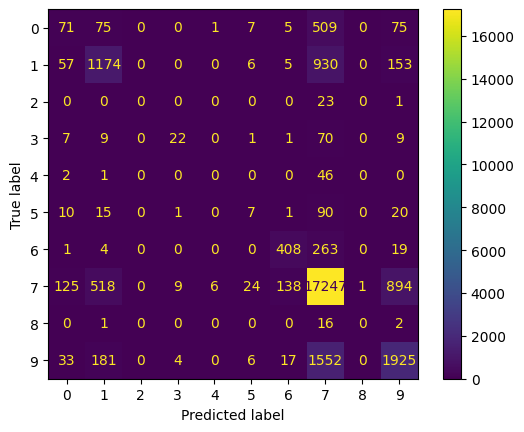

/home/knoor/.conda/envs/tfpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tfpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tfpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.23203   0.09556   0.13537       743
           1    0.59353   0.50495   0.54567      2325
           2    0.00000   0.00000   0.00000        24
           3    0.61111   0.18487   0.28387       119
           4    0.00000   0.00000   0.00000        49
           5    0.13725   0.04861   0.07179       144
           6    0.70957   0.58705   0.64252       695
           7    0.83134   0.90956   0.86869     18962
           8    0.00000   0.00000   0.00000        19
           9    0.62137   0.51775   0.56485      3718

    accuracy                        0.77819     26798
   macro avg    0.37362   0.28483   0.31128     26798
weighted avg    0.75424   0.77819   0.76245     26798


  • FINE LEVEL 


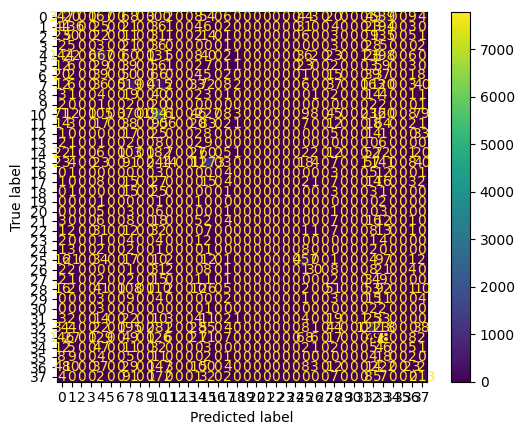

/home/knoor/.conda/envs/tfpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tfpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tfpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.33333   0.21159   0.25886      1640
           1    0.37883   0.25660   0.30596       530
           2    0.00000   0.00000   0.00000       314
           3    0.00000   0.00000   0.00000       106
           4    0.43396   0.42376   0.42880      1574
           5    0.00000   0.00000   0.00000       244
           6    0.00000   0.00000   0.00000       289
           7    0.25579   0.35210   0.29632      1474
           8    0.00000   0.00000   0.00000        96
           9    0.00000   0.00000   0.00000        30
          10    0.41412   0.58925   0.48641      3294
          11    0.48696   0.13084   0.20626       428
          12    0.00000   0.00000   0.00000       106
          13    0.00000   0.00000   0.00000        31
          14    0.10672   0.04696   0.06522       575
          15    0.58935   0.64883   0.61766      1962
          16    0.00000   0.00000   0.00000        29
          17    0.04651   0

In [25]:
metrics.lvl_wise_metric([y_true_c, y_true_m, y_true_f],
                        [y_pred_c, y_pred_m, y_pred_f])

In [26]:
h_measurements,consistency,exact_match = metrics.hmeasurements([y_true_c, y_true_m, y_true_f],
                                                               [y_pred_c, y_pred_m, y_pred_f],
                                                               dataset.get_tree())
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7334794885190437 
Hierarchical Recall = 0.7575814115481255 
Hierarchical F1-Score = 0.7436087092498019 
Consistency =  0.8694678707366221 
Exact Match =  0.4934323456974401
